# Motivation

论文原文：[《Forecasting at Scale》](https://peerj.com/preprints/3190/)

官网：https://facebook.github.io/prophet/

Prophet是工业级应用，本质是一个可加模型，基本形式如下：

$$
\begin{align}
y(t)=g(t)+s(t)+h(t)+\epsilon_t
\end{align}
$$

其中，$g(t)$是趋势项，$s(t)$是周期项，$h(t)$是节假日项，$\epsilon_t$是误差项并服从正态分布。

## 趋势模型
prophet中使用了两种趋势模型：
* 饱和增长模型（Saturating growth model）

$$
\begin{align}
g(t)=\frac{C(t)}{1+exp(-(k+a(t)^T\delta)(t-(m+a(t)^T\gamma)))}
\end{align}
$$

* 分段线性模型（Piecewise linear model）

$$
\begin{align}
g(t)=(k+a(t)^T\delta)t+(m+a(t)^T\gamma)
\end{align}
$$

## 周期模型
用傅立叶级数来建立周期模型，对N的调节起到了低通滤波（low-pass filter）的作用。原文中对于年与星期周期，N分别取为10和3效果较好

$$
\begin{align}
s(t)=\Sigma_{n=1}^N(a_ncos(\frac{2\pi nt}{P})+b_nsin(\frac{2\pi nt}{P}))
\end{align}
$$

## 节假日与突发事件模型
节假日需要用户事先指定，每一个节假日都包含其前后的若干天。模型形式为：

$$
\begin{align}
h(t)=Z(t)\kappa,\quad \text{where } Z(t)=[1(t\in D_1), ..., 1(t\in D_L)]\quad \text{and } \kappa \sim Normal(0,\nu^2) 
\end{align}
$$

# 数据读取

In [ ]:
import pandas as pd
from prophet import Prophet

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
print(df.shape)
display(df.head(), df.tail())

# ds可以除了日期，也支持到时间戳的格式 YYYY-MM-DD HH:MM:SS

(2905, 2)


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [2]:
# 饱和预测
# 通常prophet使用线性模型预测，当预测增长时，通常会有上限和下限，例如市场规模，人口数量等。这个上限可以通过设置cap和floor参数来实现饱和预测。
# 要注意，容量参数需要在训练数据中设置，然后在预测数据中也需要设置容量的值。容量值不一定为固定，可以根据时间变化。
df['cap'] = 8.5
df['floor'] = 1.5

In [ ]:
# 异常点
# 如果数据中部分日期存在丢失值，可以将这部分ds对应的数据设置为None，Prophet会自动拟合

In [ ]:
# 高阶：重大事件，e.g. 疫情导致长周期的影响
# 方案：将这类大事件设置为一次性长假

lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# We have an entry for each lockdown period, with ds specifying the start of the lockdown. ds_upper is not used by Prophet, but it’s a convenient way for us to calculate upper_window.
# upper_window tells Prophet that the lockdown spans for x days after the start of the lockdown. Note that the holidays regression is inclusive of the upper bound.

# 训练

In [ ]:
# 由于设置了cap参数，因此需要将growth参数设置为'logistic'
# changepoint_range参数设置为0.8，表示变化点只会出现在训练数据的前80%
# changepoint_prior_scale参数设置为0.05，表示变化点的灵活性较低，更加平滑的趋势变化
# 可以通过changepoints参数手动指定变化点的位置

# 通过添加holidays参数，可以将节假日效应纳入模型中，holidays相关lower_window和upper_window参数可以控制节假日前后对预测的影响范围
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

# 通过添加seasonality_mode参数，可以选择季节性模式为'additive'或'multiplicative'，以适应不同类型的季节性变化

# 通过 yearly_seasonality 
# 也可以通过 model.add_seansonality 自定义
# holidays_prior_scale

# model.add_regressor

# interval_width

# mcmc_samples

model = Prophet(growth='logistic', changepoint_range=0.8, changepoint_prior_scale=0.05, holidays=holidays, seasonality_mode='multiplicative')
model.fit(df)

18:25:50 - cmdstanpy - INFO - Chain [1] start processing
18:25:50 - cmdstanpy - INFO - Chain [1] done processing


# 预测

In [4]:
future = model.make_future_dataframe(periods=365)
future['cap'] = 8.5
future['floor'] = 1.5
print(future.shape)
display(future.head(), future.tail())

(3270, 3)


,ds,cap,floor
0,2007-12-10,8.5,1.5
1,2007-12-11,8.5,1.5
2,2007-12-12,8.5,1.5
3,2007-12-13,8.5,1.5
4,2007-12-14,8.5,1.5


,ds,cap,floor
3265,2017-01-15,8.5,1.5
3266,2017-01-16,8.5,1.5
3267,2017-01-17,8.5,1.5
3268,2017-01-18,8.5,1.5
3269,2017-01-19,8.5,1.5


In [5]:
forecast = model.predict(future)
print(forecast.shape)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(), forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

(3270, 30)


,ds,yhat,yhat_lower,yhat_upper
0,2007-12-10,8.586395,7.958232,9.210184
1,2007-12-11,8.347348,7.637611,9.019790
2,2007-12-12,8.118223,7.518857,8.770054
3,2007-12-13,8.098409,7.453988,8.722769
4,2007-12-14,8.093458,7.440208,8.755111


,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.243336,7.606349,8.920863
3266,2017-01-16,8.614209,7.976377,9.275888
3267,2017-01-17,8.423237,7.785450,9.108144
3268,2017-01-18,8.240966,7.591328,8.920956
3269,2017-01-19,8.256693,7.662643,8.908000


In [6]:
# 标记变化点
model.changepoints

93     2008-03-17
186    2008-06-20
279    2008-10-11
372    2009-01-14
465    2009-04-17
558    2009-07-19
650    2009-10-26
743    2010-01-31
836    2010-05-06
929    2010-08-14
1022   2010-11-15
1115   2011-02-16
1208   2011-05-20
1301   2011-08-21
1394   2011-11-24
1487   2012-02-27
1580   2012-05-31
1673   2012-09-01
1765   2012-12-02
1858   2013-03-05
1951   2013-06-06
2044   2013-09-08
2137   2013-12-10
2230   2014-03-14
2323   2014-06-15
Name: ds, dtype: datetime64[ns]

In [7]:
# 标记异常点
yhat_lower = forecast["yhat_lower"][:-365]
yhat_upper = forecast["yhat_upper"][:-365]
y = df["y"]
df["is_outlier"] = (y < yhat_lower) | (y > yhat_upper)

In [ ]:
# 节假日效应
forecast[(forecast["playoff"] + forecast["superbowl"]).abs() > 0][["ds", "playoff", "superbowl"][-
asd







10:]]

,ds,playoff,superbowl
34,2008-01-13,0.189255,0.000000
35,2008-01-14,0.296745,0.000000
361,2009-01-03,0.189255,0.000000
362,2009-01-04,0.296745,0.000000
730,2010-01-16,0.189255,0.000000
731,2010-01-17,0.296745,0.000000
737,2010-01-25,0.296745,0.000000
750,2010-02-07,0.189255,0.191067
1076,2011-01-08,0.189255,0.000000
1077,2011-01-09,0.296745,0.000000


# 可视化

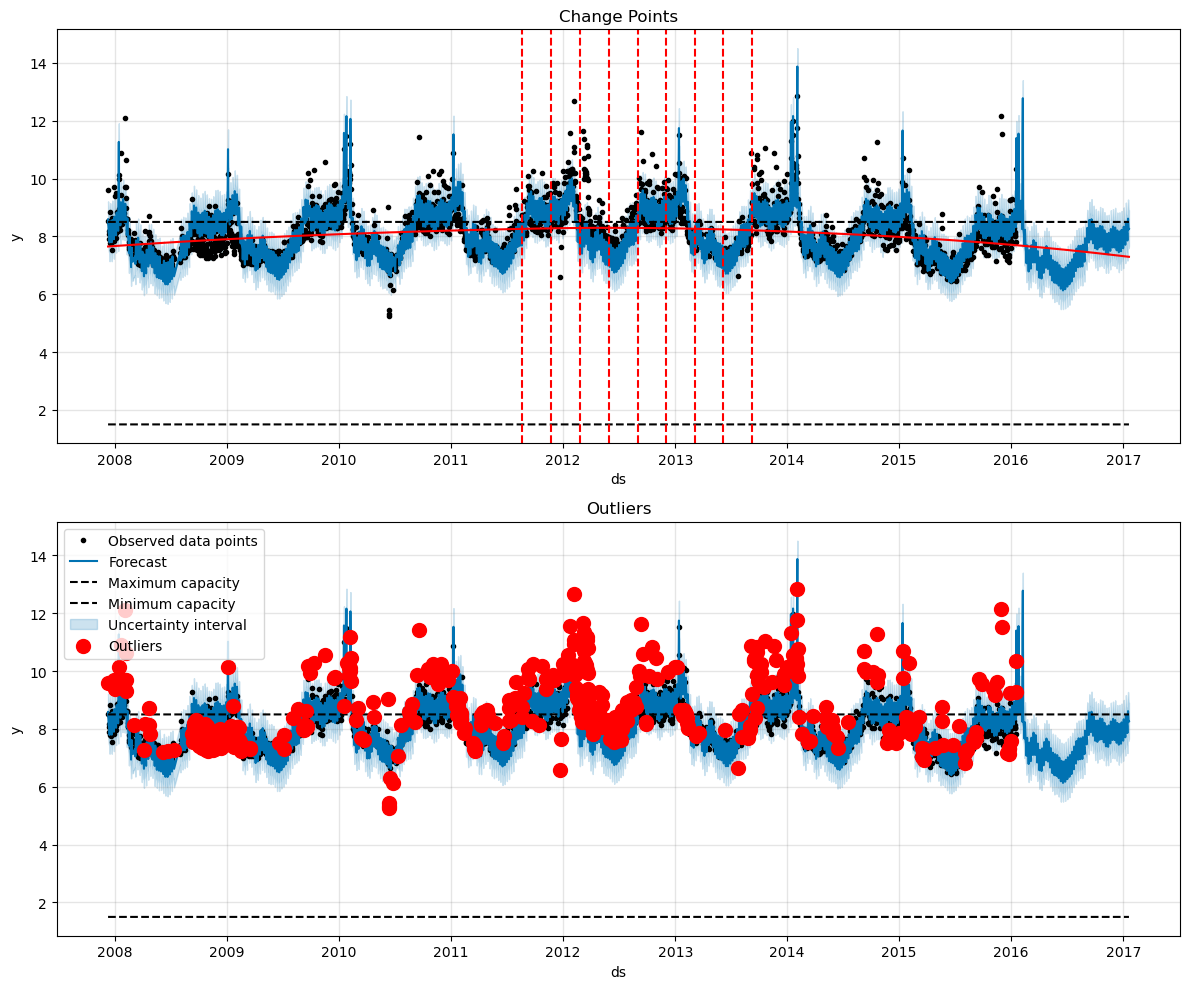

In [9]:
import matplotlib.pyplot as plt
from prophet.plot import add_changepoints_to_plot

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1. 显示变点
ax1 = axes[0]
model.plot(forecast, ax=ax1)
add_changepoints_to_plot(ax1, model, forecast)
ax1.set_title('Change Points')

# 2. 显示异常点
ax2 = axes[1]
model.plot(forecast, ax=ax2)
# 标记异常点
outliers = df[df['is_outlier']]
ax2.scatter(outliers['ds'], outliers['y'], 
           color='red', s=100, label='Outliers', zorder=5)
ax2.legend()
ax2.set_title('Outliers')

plt.tight_layout()
plt.show()

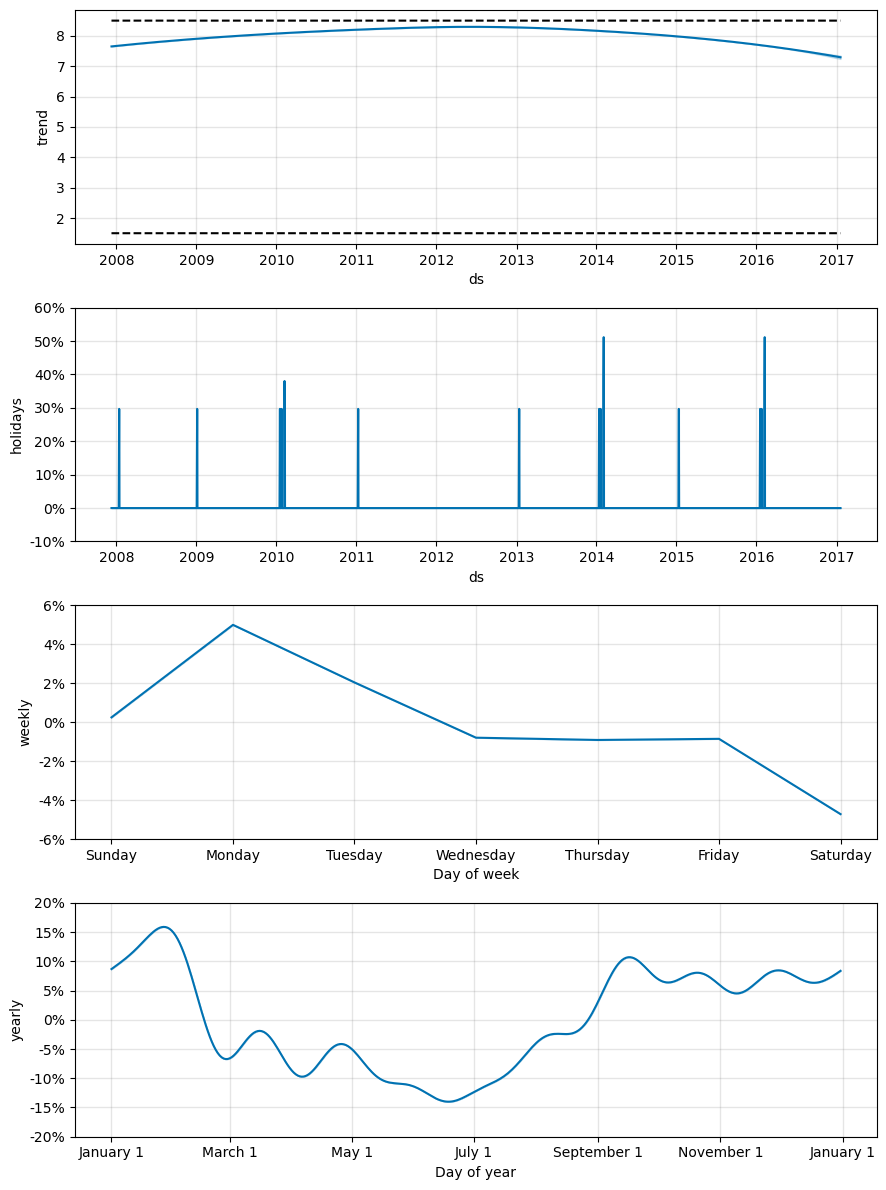

In [10]:
# 默认包含趋势性；年，季度，星期的周期性。如果模型训练时包含了季节信息，也会展现出来
fit2 = model.plot_components(forecast)

In [11]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [12]:
plot_components_plotly(model, forecast)

/opt/anaconda3/envs/howl/lib/python3.12/site-packages/plotly/io/_json.py:558: UserWarning:

Discarding nonzero nanoseconds in conversion.



# 验证

In [1]:
from prophet.diagnostics import cross_validation, performance_metrics

In [ ]:
# 自定义指标
from prophet.diagnostics import register_performance_metric, rolling_mean_by_h
import numpy as np

@register_performance_metric
def mase(df, w):
    """Mean absolute scale error

        Parameters
        ----------
        df: Cross-validation results dataframe.
        w: Aggregation window size.

        Returns
        -------
        Dataframe with columns horizon and mase.
    """
    e = (df['y'] - df['yhat'])
    d = np.abs(np.diff(df['y'])).sum()/(df['y'].shape[0]-1)
    se = np.abs(e/d)
    if w < 0:
        return pd.DataFrame({'horizon': df['horizon'], 'mase': se})
    return rolling_mean_by_h(
        x=se.values, h=df['horizon'].values, w=w, name='mase'
    )

df_mase = performance_metrics(df_cv, metrics=['mase'])
df_mase.head()


# 保存

In [ ]:
# prophet不支持pickle保存，需要用model_to_json和model_from_json方法进行保存和加载
from prophet.serialize import model_to_json, model_from_json